## Python Code: CVaR Minizing Portfolio(Tail risk)
* CVaR(Conditional Value at Risk) Minimizing Portfolio verses Max Sharpe Ratio Verses MVO portfolio.


### Data
The portfolio consist of 12 major U.S. equities with defensive and diversifying assets such as cash, short-duration Treasuries, and gold.

* All data is from Yahoo Finance.

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, linprog


### Simple Version of CVaR Minimizing Portfolio.

Data Period: 2020-01-01 - 2025-01-01

In [10]:
# Composition of portfolio
tickers = ["NVDA", "AAPL", "MSFT", "GOOGL", "AMZN", "META", "AVGO", "TSLA", "BRK-B", "JPM",         # Major stocks in S&P 500
            "UNH","JNJ",                                                                            # Health care stocks
            "BIL", "SHV","GLD"                                                                      # cash, short-duration Treasuries, and gold
            ]

data = yf.download(tickers, start="2020-01-01", end="2025-01-01", auto_adjust=False)
daily_returns = data.xs('Adj Close', axis=1, level=0).pct_change().dropna()
daily_returns = daily_returns[tickers]


[*********************100%***********************]  15 of 15 completed


CVaR-Based Portfolio Optimization (Linear Programming)
* Construct a portfolio that minimizes Conditional Value-at-Risk (CVaR) at the 95% confidence level.
* Focus on downside tail risk.

Framework
* Define portfolio losses as the negative of asset returns.
* Use the Rockafellar–Uryasev linear programming formulation of CVaR.
* Estimate one-shot CVaR optimization using the full empirical distribution of daily returns (no parametric assumptions).
* Portfolio weights are optimized ex ante based on historical tail behavior.

Asset-level weight bounds (Long-only portfolio)
* Core mega-cap stocks (e.g., AAPL, MSFT): Min 2%, Max 20%
* High-volatility growth stocks (e.g., NVDA, TSLA): Max 15%
* Large-cap growth stocks (e.g., GOOGL, AMZN, META, AVGO): Max 18%
* Financial stocks: cMax 15%
* Cash, short-duration Treasuries, and gold: Max 5%
* others : Max 15%

In [11]:
# Bounds for each stocks
bounds = []
for t in tickers:
    if t in ["AAPL", "MSFT"]:
        bounds.append((0.02, 0.20))   # Core stocks: Min 2%, Max 20%
    elif t in ["NVDA", "TSLA"]:
        bounds.append((0.00, 0.15))   # High vol stocks: Max 15%
    elif t in ["GOOGL", "AMZN", "META", "AVGO"]:
        bounds.append((0.00, 0.18))   # large-cap growth stocks: Max 18%
    elif t in ["BRK-B", "JPM"]:
        bounds.append((0.00, 0.15))   # Finance: Max 15%
    elif t in ["BIL", "SHV","GLD"]:
        bounds.append((0.00, 0.05))   # cash, short-duration Treasuries, and gold
    else:
        bounds.append((0.00, 0.15))

In [12]:
# CVaR Minimization Function
def minimize_cvar(returns, bounds, alpha=0.95):
    T, N = returns.shape
    loss = -returns.values
    c = np.zeros(N + T + 1)
    c[N] = 1.0
    c[N+1:] = 1.0 / ((1 - alpha) * T)

    A_ub = np.zeros((T, N + T + 1))
    A_ub[:, :N] = loss
    A_ub[:, N] = -1.0
    A_ub[:, N+1:] = -np.eye(T)
    b_ub = np.zeros(T)

    A_eq = np.zeros((1, N + T + 1))
    A_eq[0, :N] = 1.0
    b_eq = [1.0]

    full_bounds = bounds + [(None, None)] + [(0.0, None)] * T

    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                     bounds=full_bounds, method='highs')

    if result.success:
        weights = result.x[:N]
        var = result.x[N]
        cvar = result.fun
        return weights, var, cvar
    else:
        raise ValueError("CVaR optimization failed.")

# Run Optimization
opt_weights, var, cvar = minimize_cvar(daily_returns, bounds)
weights_df = pd.DataFrame(opt_weights, index=tickers, columns=["CVaR Weight"]).round(4)

# Output
print(weights_df[weights_df["CVaR Weight"] > 0])
print(f"\nEstimated Portfolio VaR (95%): {var:.3%}")
print(f"Estimated Portfolio CVaR (95%): {cvar:.3%}")


       CVaR Weight
AAPL        0.0324
MSFT        0.1197
GOOGL       0.0466
AMZN        0.0872
BRK-B       0.1500
JPM         0.1140
UNH         0.1500
JNJ         0.1500
BIL         0.0500
SHV         0.0500
GLD         0.0500

Estimated Portfolio VaR (95%): 1.474%
Estimated Portfolio CVaR (95%): 2.575%


## Monthly Rebalancing CVaR Backtest (12-Month Rolling Window)

### Framework
* This section implements a monthly rebalanced portfolio strategy. 
* At each month $t$, portfolio weights are re-optimized by minimizing CVaR using the most recent 12 months of return data. 
* The resulting weights are applied to the next month’s realized returns to generate the strategy’s backtested performance.

In [13]:
#------------------------------------------------------
# Monthly Rebalancing
#------------------------------------------------------

# This will be used for Pie Chart

# Monthly Compounded Return
monthly_returns = daily_returns.resample('MS').apply(lambda x: (x + 1).prod() - 1)

# 5. Monthly Rebalancing and Backtesting
weights_history = []
portfolio_returns = []

for i in range(12, len(monthly_returns)):
    # Daily returns for 12 month windows.
    start = monthly_returns.index[i-12]
    end = monthly_returns.index[i]
    window = daily_returns.loc[start:end]

    # Optimized weights
    weights,_ ,_ = minimize_cvar(window, bounds)
    weights_history.append(weights)

    # Monthly return for each windows
    this_month_return = np.dot(weights, monthly_returns.iloc[i])
    portfolio_returns.append(this_month_return)

# 6. Results
portfolio_returns_CVaR = pd.DataFrame(portfolio_returns,columns= ['Portfolio Return'], index=monthly_returns.index[12:]).round(4)
weights_CVaR = pd.DataFrame(weights_history, columns=tickers, index=monthly_returns.index[12:]).round(3)

# Cumulative Return
portfolio_returns_CVaR["Cumulative Return"] = (1 + portfolio_returns_CVaR["Portfolio Return"]).cumprod()

#------------------------------------------------------
#  Evaluate Portfolio.
#------------------------------------------------------

# Sharpe Ratio
mean_return = np.mean(portfolio_returns_CVaR["Portfolio Return"]) * 12
volatility = np.std(portfolio_returns_CVaR["Portfolio Return"]) * np.sqrt(12)
sharpe_ratio = mean_return / volatility

# Calculate VaR
var_95 = -np.percentile(portfolio_returns_CVaR["Portfolio Return"],5)

# Calculate CVaR
def cvar_calculation(returns, alpha=0.95):
    loss = -np.asarray(returns)
    var_95 = -np.percentile(returns,(1-alpha)*100)
    tail_loss = loss[loss >= var_95]
    return np.mean(tail_loss)

portfolio_return= portfolio_returns_CVaR["Portfolio Return"]

cvar_95= cvar_calculation(portfolio_return, alpha=0.95)

print(f"Annualized Return: {mean_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"VaR (95%): {var_95:.2%}")
print(f"CVaR (95%): {cvar_95:.2%}")

Annualized Return: 13.07%
Annualized Volatility: 12.52%
Sharpe Ratio: 1.04
VaR (95%): 4.90%
CVaR (95%): 5.88%


In [14]:
# Visualization (Using Monthly rebalancing Portfolio)

def yearly_pie_charts(
    year, 
    weights_df
    ):

    months = weights_df.index[weights_df.index.year == year]
    
    if len(months) == 0:
        print(f"No data available for year {year}.")
        return

    # subplots for 12 months
    fig, axes = plt.subplots(4, 3, figsize=(20, 20), facecolor='white')
    axes = axes.flatten()

    # Iterate for 12 month window
    for i, month in enumerate(months[:12]):  # 최대 12개월까지만
        # locate weights for each months
        monthly_weights = weights_df.loc[month]
        weights_above_0 = monthly_weights[monthly_weights > 1e-4]  # Only above 0.01%
        
        # Draw Pie Charts
        axes[i].pie(
            weights_above_0,
            labels=weights_above_0.index,
            autopct='%1.2f%%'
        )
        axes[i].set_title(f"Monthly Portfolio Weights - {month.strftime('%Y-%m')}")
        axes[i].set_facecolor('white')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Monthly Rebalanced Portfolio Weights - {year}", fontsize=20, y=1.03)
    plt.show()

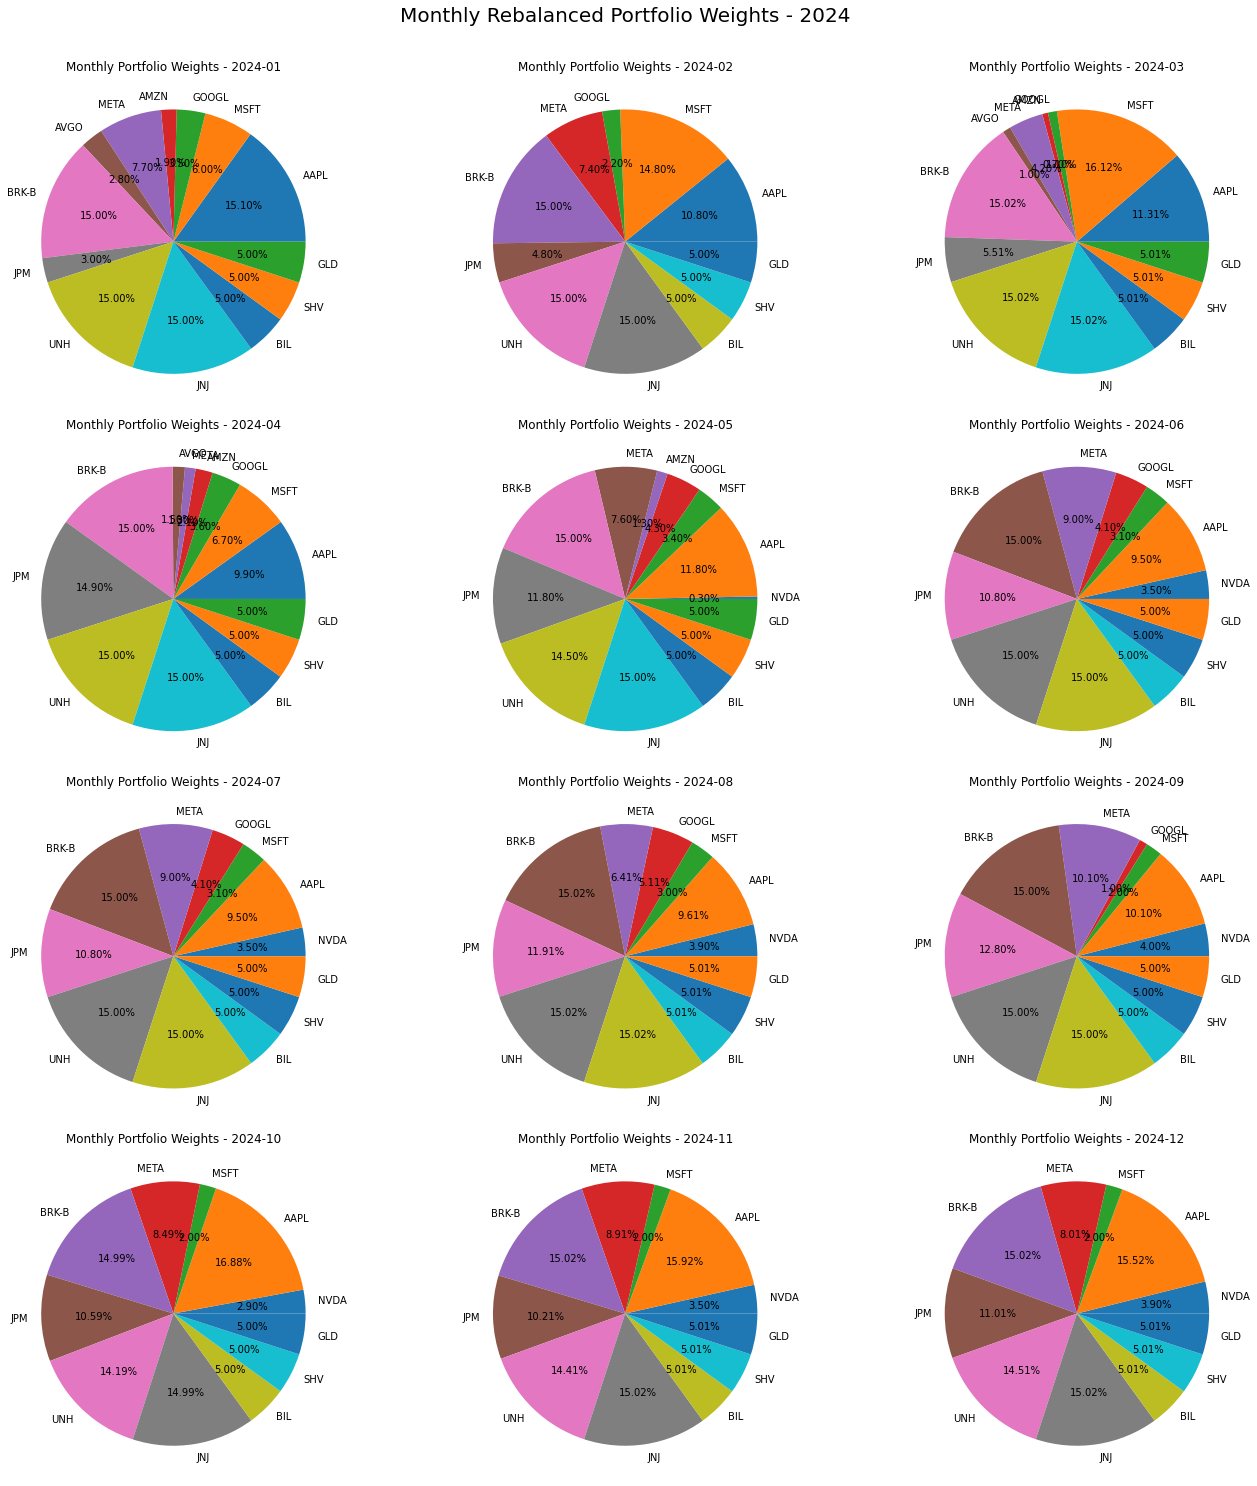

In [15]:
# Portfolio 2023
yearly_pie_charts(2024,weights_CVaR)

## Weekly Rebalancing CVaR Strategy (26-Week Lookback, Daily Return)

* This section implements a weekly rebalanced CVaR-minimizing strategy.
* This produces a daily return series for a strategy whose weights are updated weekly.
* At each rebalance date (Friday), the model:
    * estimates CVaR-minimizing weights using the past 26 weeks of daily returns, 
    * applies those weights to construct the next week’s portfolio returns on a daily basis (i.e., daily return within the week).

### Key Difference vs. Monthly Rebalancing Version

* Weights update weekly, but returns are measured daily.
* More precise volatility / drawdown behavior analysis,
* better alignment with daily risk reporting.

In [16]:
#------------------------------------------------------
# Weekly Rebalancing 
# A daily portfolio return series by holding weights constant within each week.
#------------------------------------------------------

# Weekly Compounded Return
weekly_returns = daily_returns.resample('W-FRI').apply(lambda x: (x + 1).prod() - 1)

# Weekly Rebalancing and Backtesting
weights_week = []
portfolio_returns_daily = []

# 26-week lookback window
lookback_window= 26

for i in range(lookback_window, len(weekly_returns)):
    # Daily returns for 26 weeks windows; avoid look ahead
    end = weekly_returns.index[i-1] # Last Friday which should be exclude.
    start = end - pd.DateOffset(weeks=lookback_window) # Friday 26 weeks before.
    window_range= (daily_returns.index > start) & (daily_returns.index <= end)

    window = daily_returns.loc[window_range]

    # Optimized weights
    weights,_ ,_ = minimize_cvar(window, bounds)
    weights_week.append(weights)

    # Daily Portfolio Return using weekly Rebalanced portfolio weights
    start_day = weekly_returns.index[i-1]
    end_day = weekly_returns.index[i]
    window_trade= (daily_returns.index > start_day) & (daily_returns.index <= end_day)

    portfolio_day_rebalanced = daily_returns.loc[window_trade].dot(weights)
    portfolio_returns_daily.append(portfolio_day_rebalanced)

# 6. Results
weights_CVaR_week = pd.DataFrame(weights_week, columns=tickers, index=weekly_returns.index[lookback_window:]).round(3)

portfolio_daily_return = pd.concat(portfolio_returns_daily).sort_index()
portfolio_daily_return.name = "Portfolio Return"

portfolio_daily_return_CVaR = pd.DataFrame(portfolio_daily_return)

# Cumulative Return
portfolio_daily_return_CVaR["Cumulative Return"] = (1 + portfolio_daily_return_CVaR["Portfolio Return"]).cumprod()
portfolio_daily_return_CVaR["Cumulative Return(%)"] = ((1 + portfolio_daily_return_CVaR["Portfolio Return"]).cumprod()-1)*100

#------------------------------------------------------
#  Evaluate Portfolio.
#------------------------------------------------------

# Sharpe Ratio
mean_return = np.mean(portfolio_daily_return_CVaR["Portfolio Return"]) * 252
volatility = np.std(portfolio_daily_return_CVaR["Portfolio Return"]) * np.sqrt(252)
sharpe_ratio = mean_return / volatility

# Calculate VaR
var_95 = -np.percentile(portfolio_daily_return_CVaR["Portfolio Return"],5)

# Calculate CVaR
def cvar_calculation(returns, alpha=0.95):
    loss = -np.asarray(returns)
    var_95 = -np.percentile(returns,(1-alpha)*100)
    tail_loss = loss[loss >= var_95]
    return np.mean(tail_loss)

portfolio_return= portfolio_daily_return_CVaR["Portfolio Return"]

cvar_95= cvar_calculation(portfolio_return, alpha=0.95)

print(f"Annualized Return: {mean_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"VaR (95%): {var_95:.2%}")
print(f"CVaR (95%): {cvar_95:.2%}")



Annualized Return: 20.32%
Annualized Volatility: 13.64%
Sharpe Ratio: 1.49
VaR (95%): 1.36%
CVaR (95%): 1.90%


In [17]:
portfolio_daily_return_CVaR.head()

,Portfolio Return,Cumulative Return,Cumulative Return(%)
Date,,,
2020-06-29,0.009030,1.009030,0.902961
2020-06-30,0.014579,1.023740,2.374016
2020-07-01,0.012048,1.036075,3.607460
2020-07-02,0.005754,1.042036,4.203613
2020-07-06,0.023220,1.066232,6.623230


In [18]:
weights_CVaR_week

,NVDA,AAPL,MSFT,GOOGL,AMZN,META,AVGO,TSLA,BRK-B,JPM,UNH,JNJ,BIL,SHV,GLD
Date,,,,,,,,,,,,,,,
2020-07-03,0.000,0.020,0.02,0.18,0.18,0.017,0.0,0.0,0.15,0.000,0.133,0.15,0.05,0.05,0.05
2020-07-10,0.000,0.020,0.02,0.18,0.18,0.017,0.0,0.0,0.15,0.000,0.133,0.15,0.05,0.05,0.05
2020-07-17,0.000,0.020,0.02,0.18,0.18,0.017,0.0,0.0,0.15,0.000,0.133,0.15,0.05,0.05,0.05
2020-07-24,0.000,0.020,0.02,0.18,0.18,0.017,0.0,0.0,0.15,0.000,0.133,0.15,0.05,0.05,0.05
2020-07-31,0.000,0.020,0.02,0.18,0.18,0.017,0.0,0.0,0.15,0.000,0.133,0.15,0.05,0.05,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06,0.000,0.097,0.02,0.00,0.00,0.137,0.0,0.0,0.15,0.150,0.146,0.15,0.05,0.05,0.05
2024-12-13,0.000,0.097,0.02,0.00,0.00,0.137,0.0,0.0,0.15,0.150,0.146,0.15,0.05,0.05,0.05
2024-12-20,0.000,0.099,0.02,0.00,0.00,0.131,0.0,0.0,0.15,0.150,0.150,0.15,0.05,0.05,0.05


### Portfolio Weight Dynamics by sectors

In [19]:
def plot_weights(
    weights,
    sector
    ):
    """

    Plot portfolio weight dynamics by asset groups (line plots).
    
    """

    n = len(sector)
    fig, axes = plt.subplots(n, 1, figsize=(14,12))  
    
    for ax, (sectors, assets) in zip(axes, sector.items()):
        weights[assets].plot(ax=ax)
        ax.set_title(sectors)
        ax.set_ylabel("Weight")
        ax.legend(loc="upper right", ncol=3)
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()

In [20]:
groups = {
    "Growth / Tech": ["NVDA","AAPL","MSFT","GOOGL","AMZN","META"],
    "Financial": ["BRK-B","JPM"],
    "Defensive": ["UNH","JNJ"],
    "Hedge / Cash": ["BIL","SHV","GLD"]
}


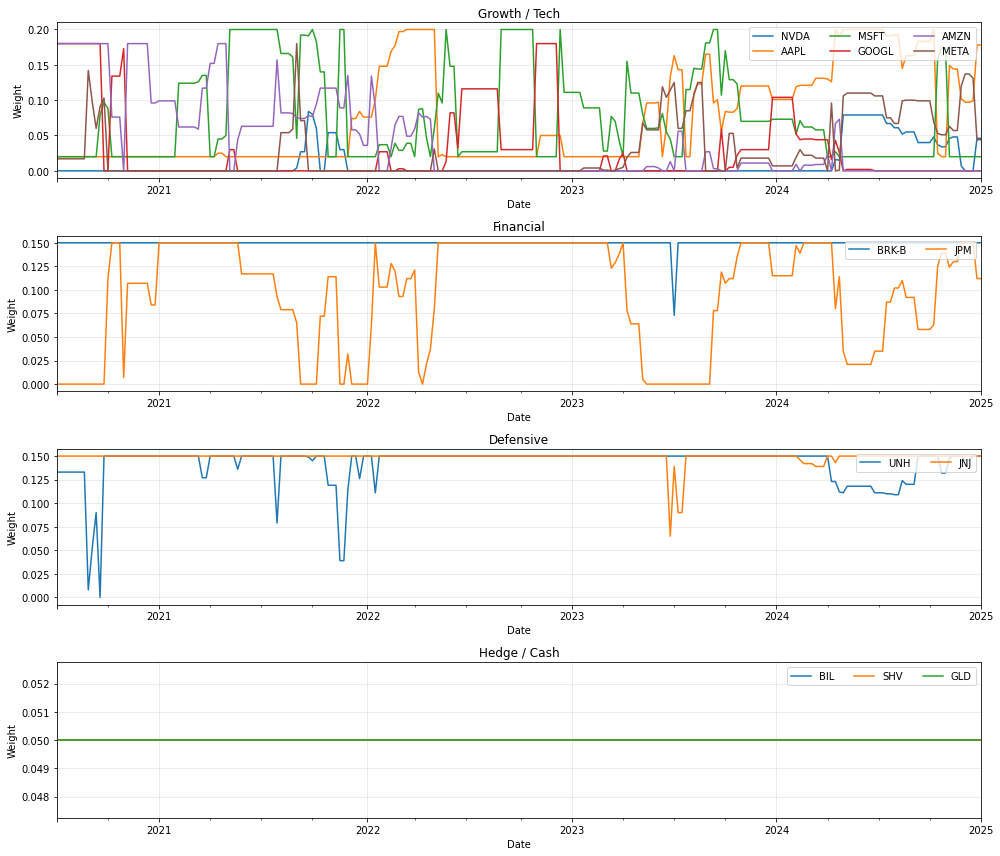

In [21]:
# Weekly rebalancing framework
plot_weights(weights_CVaR_week,groups)

### Graph of Daily Return

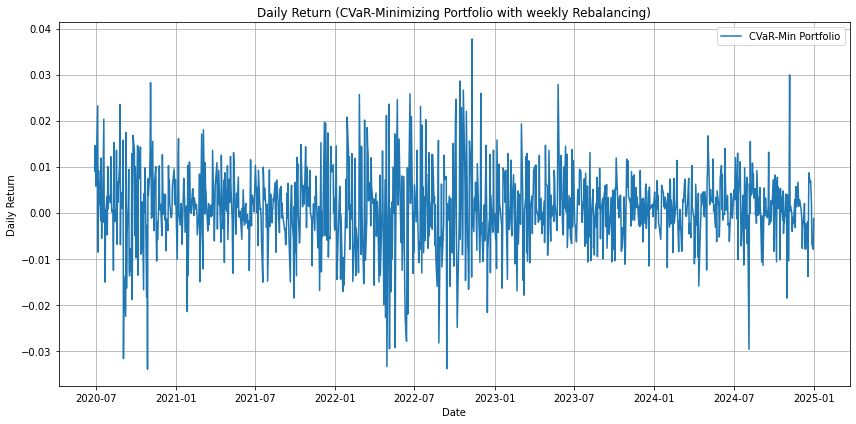

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_daily_return_CVaR.index, portfolio_daily_return_CVaR["Portfolio Return"], label="CVaR-Min Portfolio")
plt.title("Daily Return (CVaR-Minimizing Portfolio with weekly Rebalancing)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Compounded Return

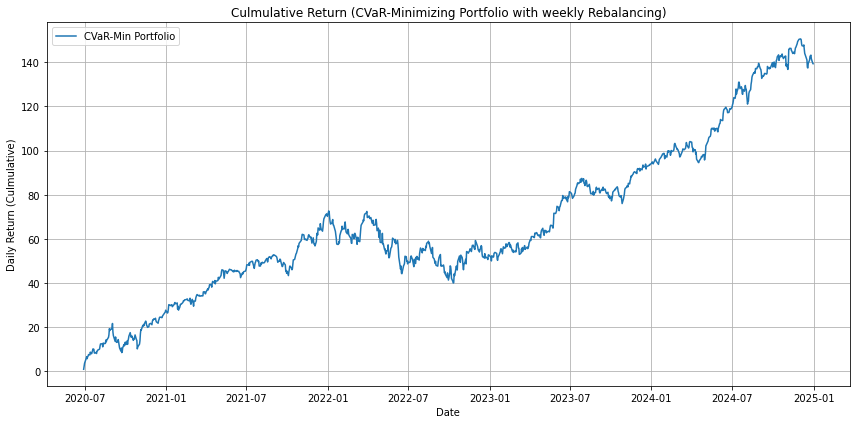

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_daily_return_CVaR.index, portfolio_daily_return_CVaR["Cumulative Return(%)"], label="CVaR-Min Portfolio")
plt.title("Culmulative Return (CVaR-Minimizing Portfolio with weekly Rebalancing)")
plt.xlabel("Date")
plt.ylabel("Daily Return (Culmulative)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Our Baseline model is Daily portfolio return rebalanced weekly.

## Calculate ES shares

### Marginal ES
* measures how much the portfolio’s Expected Shortfall would change if the weight of an asset were increased infinitesimally.
* captures the tail riskiness of an asset itself, independent of its current portfolio weight.
* reflects sensitivity

### Component ES
* measures how much of the portfolio’s Expected Shortfall is actually contributed by each asset.
* incorporates both the asset’s tail behavior and its portfolio weight

In [24]:
# ------------------------------------------------------------------------------
# Set up
# ------------------------------------------------------------------------------
daily_block = daily_returns.copy()
daily_block["week"] = daily_block.index.to_period("W-FRI").to_timestamp("W-FRI")
daily_w = daily_block[["week"]].join(weights_CVaR_week, on="week").dropna()

# Return and Weights
R = daily_block.loc[daily_w.index, tickers].values
w = daily_w[tickers].values

# Calculate Losses
loss_asset = -(R * w)          # (T, N)
loss_port  = loss_asset.sum(axis=1)

alpha = 0.95
VaR = np.quantile(loss_port, alpha)
thres = loss_port >= VaR

# ------------------------------------------------------------------------------
# Marginal ES
# Calculated with Finite Difference
# ------------------------------------------------------------------------------

ES_base = cvar_calculation(-loss_port, alpha=alpha)

# Set up
epsilon = 1e-4
N = len(tickers)
mES = np.zeros(N)

# Slight increase in the weights of each assets
for i in range(N):
    w_shift = w.copy()
    w_shift[:, i] += epsilon

    # This is a "leverage-up" perturbation (sum(w) increases slightly)
    loss_port_shift = (-(R * w_shift)).sum(axis=1)
    ES_pert = cvar_calculation(-loss_port_shift, alpha=alpha)

    mES[i] = (ES_pert - ES_base) / epsilon

# ------------------------------------------------------------------------------
# Component(Compouned) ES
# ------------------------------------------------------------------------------
cES = (-(R * w))[thres].mean(axis=0)

# Proxy can be calculated by mean_weights * mES as well.
mean_weights = w[thres].mean(axis=0)
cES_xy = mean_weights*mES

# ------------------------------------------------------------------------------
# Calculate ES shares for each assets
# ------------------------------------------------------------------------------
ES_total = loss_port[thres].mean()
share = cES / ES_total

# Result
marginal_ES_df = pd.DataFrame({
    "Mean Weight": mean_weights,
    "Marginal ES": mES,
    "Component ES": cES,
    "Component ES (Proxy)": cES_xy,
    "ES Share": share
}, index=tickers).round(6)

print("=== Historical Marginal & Component ES ===")
print(f"Portfolio Total ES (95%): {ES_total:.6%}\n")
print(marginal_ES_df)



=== Historical Marginal & Component ES ===
Portfolio Total ES (95%): 1.899867%

       Mean Weight  Marginal ES  Component ES  Component ES (Proxy)  ES Share
NVDA      0.006123     0.043824      0.000282              0.000268  0.014820
AAPL      0.062246     0.029019      0.001785              0.001806  0.093965
MSFT      0.077158     0.030850      0.002463              0.002380  0.129656
GOOGL     0.045404     0.030960      0.001466              0.001406  0.077157
AMZN      0.053456     0.035819      0.001901              0.001915  0.100076
META      0.016018     0.033002      0.000506              0.000529  0.026650
AVGO      0.052246     0.026837      0.001661              0.001402  0.087437
TSLA      0.008246     0.042111      0.000336              0.000347  0.017678
BRK-B     0.150000     0.016045      0.002407              0.002407  0.126678
JPM       0.093825     0.020520      0.002220              0.001925  0.116839
UNH       0.135351     0.016169      0.002237              0.0

## Compare the result with Max-Sharpe Portfolio

Same Framework except for the objective function.

### Weekly Rebalancing Max-Sharpe Strategy (26-Week Lookback, Daily Return)

In [25]:
# Bounds for each stocks
bounds = []
for t in tickers:
    if t in ["AAPL", "MSFT"]:
        bounds.append((0.02, 0.20))   # Core stocks: Min 2%, Max 20%
    elif t in ["NVDA", "TSLA"]:
        bounds.append((0.00, 0.15))   # High vol stocks: Max 15%
    elif t in ["GOOGL", "AMZN", "META", "AVGO"]:
        bounds.append((0.00, 0.18))   # large-cap growth stocks: Max 18%
    elif t in ["BRK-B", "JPM"]:
        bounds.append((0.00, 0.15))   # Finance: Max 15%
    elif t in ["BIL", "SHV","GLD"]:
        bounds.append((0.00, 0.05))   # cash, short-duration Treasuries, and gold
    else:
        bounds.append((0.00, 0.15))

In [26]:
# Weekly Rebalancing & use the weight to construct the week's portfolio return in daily.
# Max-Sharpe Ratio
num_assets = len(tickers)

# Function to compute weights via Sharpe Ratio maximization
def max_sharpe(return_window, rf=0.02):
    mean_returns = return_window.mean() * 252
    cov_matrix = return_window.cov() * 252
    n = len(mean_returns)

    def objective(w):
        ret = np.dot(w, mean_returns)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        return -(ret - rf) / vol

    init = [1/n] * n
    
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(objective, init, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Weekly Compounded Return
weekly_returns = daily_returns.resample('W-FRI').apply(lambda x: (x + 1).prod() - 1)

# Weekly Rebalancing and Backtesting
weights_week = []
portfolio_returns_daily = []

# 26-week lookback window
lookback_window= 26

for i in range(lookback_window, len(weekly_returns)):
    # Daily returns for 26 weeks windows.
    end = weekly_returns.index[i-1] # Last Friday which should be exclude.
    start = end - pd.DateOffset(weeks=lookback_window) # Friday 26 weeks before.
    window_range= (daily_returns.index > start) & (daily_returns.index <= end)

    window = daily_returns.loc[window_range]

    # Optimized weights
    weights = max_sharpe(window)
    weights_week.append(weights)

    # Daily Portfolio Return using weekly Rebalanced portfolio weights
    start_day = weekly_returns.index[i-1]
    end_day = weekly_returns.index[i]
    window_trade= (daily_returns.index > start_day) & (daily_returns.index <= end_day)

    portfolio_day_rebalanced = daily_returns.loc[window_trade].dot(weights)
    portfolio_returns_daily.append(portfolio_day_rebalanced)

# 6. Results
weights_week_sharpe = pd.DataFrame(weights_week, columns=tickers, index=weekly_returns.index[lookback_window:]).round(3)

portfolio_daily_return_sharpe = pd.concat(portfolio_returns_daily).sort_index()
portfolio_daily_return_sharpe.name = "Portfolio Return"

portfolio_daily_return_sharpe = pd.DataFrame(portfolio_daily_return_sharpe)

# Cumulative Return
portfolio_daily_return_sharpe["Cumulative Return"] = (1 + portfolio_daily_return_sharpe["Portfolio Return"]).cumprod()
portfolio_daily_return_sharpe["Cumulative Return(%)"] = ((1 + portfolio_daily_return_sharpe["Portfolio Return"]).cumprod()-1)*100

#---------------------------
#  Evaluate Portfolio
#---------------------------

# Sharpe Ratio
mean_return = np.mean(portfolio_daily_return_sharpe["Portfolio Return"]) * 252
volatility = np.std(portfolio_daily_return_sharpe["Portfolio Return"]) * np.sqrt(252)
sharpe_ratio = mean_return / volatility

# Calculate VaR
var_95 = -np.percentile(portfolio_daily_return_sharpe["Portfolio Return"],5)

# Calculate CVaR
def cvar_calculation(returns, alpha=0.95):
    loss = -np.asarray(returns)
    var_95 = -np.percentile(returns,(1-alpha)*100)
    tail_loss = loss[loss >= var_95]
    return np.mean(tail_loss)

portfolio_return_Max= portfolio_daily_return_sharpe["Portfolio Return"]

cvar_95= cvar_calculation(portfolio_return_Max, alpha=0.95)

print(f"Annualized Return: {mean_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"VaR (95%): {var_95:.2%}")
print(f"CVaR (95%): {cvar_95:.2%}")

/Users/choejunhoe/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/choejunhoe/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/choejunhoe/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Annualized Return: 26.33%
Annualized Volatility: 18.98%
Sharpe Ratio: 1.39
VaR (95%): 1.84%
CVaR (95%): 2.67%


#### CVaR verses Max Sharpe Portfolio

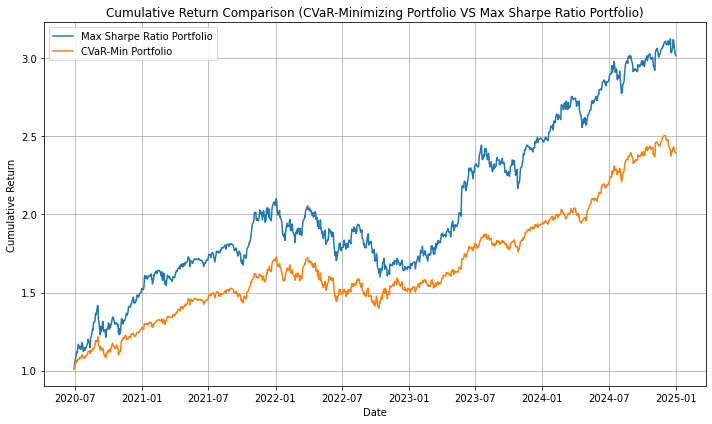

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_daily_return_sharpe.index, portfolio_daily_return_sharpe["Cumulative Return"], label="Max Sharpe Ratio Portfolio")
plt.plot(portfolio_daily_return_CVaR.index, portfolio_daily_return_CVaR["Cumulative Return"], label="CVaR-Min Portfolio")
plt.title("Cumulative Return Comparison (CVaR-Minimizing Portfolio VS Max Sharpe Ratio Portfolio)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Calculate risk with GARCH(1,1)

In [28]:
from arch import arch_model

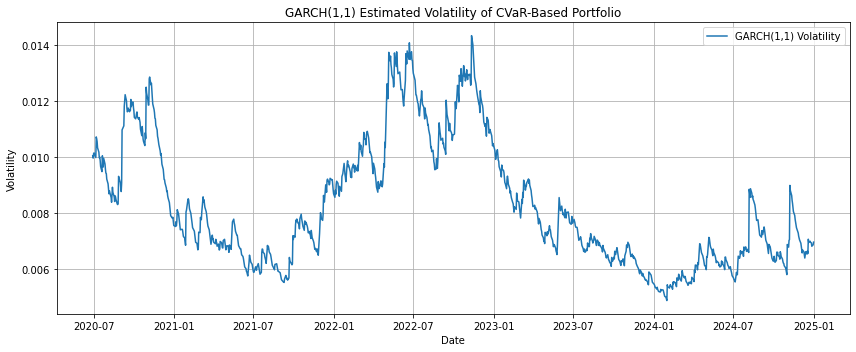

In [79]:
# Calculate Risk with GARCH(1,1)
# GARCH is better in %unit
returns_GARCH = portfolio_daily_return_CVaR["Portfolio Return"] * 100

# Fit GARCH(1,1)
garch_CVaR = arch_model(returns_GARCH,mean='constant', vol='GARCH', p=1, q=1).fit(disp='off')

# Conditional volatility
# Return to decimals
conditional_vol_CVaR = garch_CVaR.conditional_volatility / 100  

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(conditional_vol_CVaR, label='GARCH(1,1) Volatility')
plt.title('GARCH(1,1) Estimated Volatility of CVaR-Based Portfolio')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


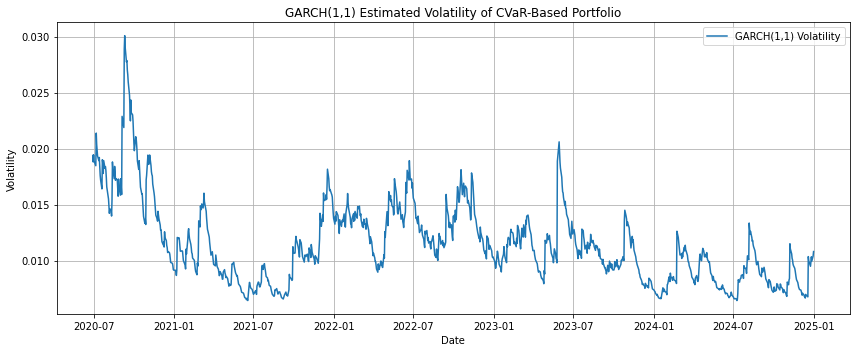

In [80]:
# Calculate Risk with GARCH(1,1)
# GARCH is better in %unit
returns_GARCH = portfolio_daily_return_sharpe["Portfolio Return"] * 100

# Fit GARCH(1,1)
garch_CVaR = arch_model(returns_GARCH,mean='constant', vol='GARCH', p=1, q=1).fit(disp='off')

# Conditional volatility
# Return to decimals
conditional_vol_sharpe = garch_CVaR.conditional_volatility / 100  

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(conditional_vol_sharpe, label='GARCH(1,1) Volatility')
plt.title('GARCH(1,1) Estimated Volatility of CVaR-Based Portfolio')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


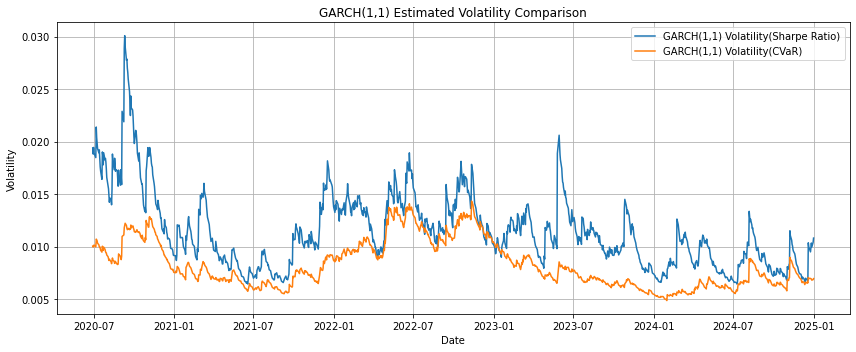

In [81]:
plt.figure(figsize=(12, 5))
plt.plot(conditional_vol_sharpe, label='GARCH(1,1) Volatility(Sharpe Ratio)')
plt.plot(conditional_vol_CVaR, label='GARCH(1,1) Volatility(CVaR)')
plt.title('GARCH(1,1) Estimated Volatility Comparison')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [82]:
# Compare Average and Max level of volatility
print("<Compare Average and Max level of volatility>")
print("="*45)
print(f"Avg Volatility of CVaR portfolio: {conditional_vol_CVaR.mean():.2%}")
print(f"Avg Volatility of Sharpe portfolio: {conditional_vol_sharpe.mean():.2%}")
print("="*45)
print(f"Avg Volatility of CVaR portfolio: {conditional_vol_CVaR.max():.2%}")
print(f"Avg Volatility of Sharpe portfolio: {conditional_vol_sharpe.max():.2%}")

<Compare Average and Max level of volatility>
Avg Volatility of CVaR portfolio: 0.83%
Avg Volatility of Sharpe portfolio: 1.15%
Avg Volatility of CVaR portfolio: 1.43%
Avg Volatility of Sharpe portfolio: 3.01%


### Appendix: Using GARCH, GJR-GARCH, SVR-GARCH, build volatility forecasting model 
* Evaluate with MSE.

In [34]:
from sklearn.metrics import mean_squared_error as mse

In [35]:
split_date= portfolio_daily_return_CVaR["Portfolio Return"].iloc[-126:].index

# Hull evaluate volatility forecasts by using a 5-day rolling standard deviation of daily returns as proxy for realized volatility.
real_vol= portfolio_daily_return_CVaR["Portfolio Return"].rolling(5).std()
real_vol_test=real_vol[split_date]

# Forecast
# Forecasting using GARCH(1,1)

forecast= garch_CVaR.forecast(start=split_date[0])
forecast_vol= np.sqrt(forecast.variance.iloc[:,0])/100

In [36]:
# RMSE to evaluate the forecast.

def RMSE(real_vol,forecast_vol):
    fv,rv = forecast_vol.align(real_vol,join='inner')
    rmse = np.sqrt(mse(fv,rv))
    return rmse

In [37]:
rmse_garch=RMSE(real_vol_test,forecast_vol)
print('The RMSE value of GARCH Model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH Model is 0.0034


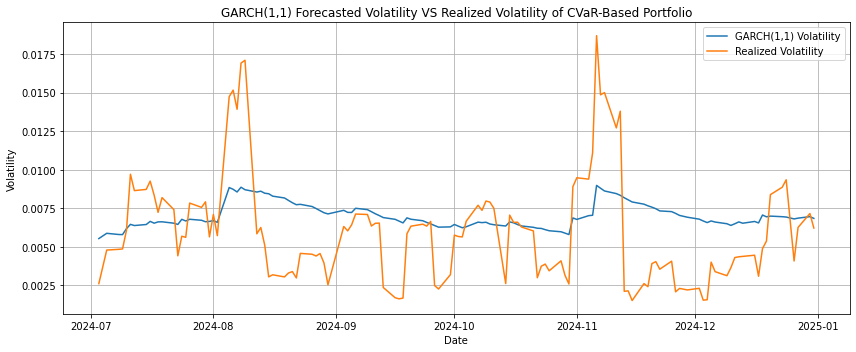

In [38]:
# Forecast VS Realized

plt.figure(figsize=(12, 5))
plt.plot(forecast_vol, label='GARCH(1,1) Volatility')
plt.plot(real_vol_test, label='Realized Volatility')
plt.title('GARCH(1,1) Forecasted Volatility VS Realized Volatility of CVaR-Based Portfolio')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Use GJR-GARCH

bic_gjr = []

for p in range(1,5):
    for q in range(1,5):
        gjrgarch = arch_model(portfolio_daily_return_CVaR["Portfolio Return"], 
                                mean='zero', p=p,o=1,q=q).fit(disp='off')
        bic_gjr.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr):
            best_param = p,q

p,q

/Users/choejunhoe/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/choejunhoe/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/choejunhoe/opt/anaconda3/lib/python

(4, 4)

In [74]:
gjr_garch = arch_model(portfolio_daily_return_CVaR["Portfolio Return"]*100,
                                mean='constant', p=p,o=1,q=q).fit(disp='off')

forecast_gjr= gjr_garch.forecast(start=split_date[0])
forecast_gjr_vol= np.sqrt(forecast_gjr.variance.iloc[:,0])/100

rmse_gjr = RMSE(real_vol_test,forecast_gjr_vol)

print(f'The RMSE value of GJR-GARCH Model is {rmse_gjr:.7f}')
print(f'The RMSE value of GARCH Model is {rmse_garch:.7f}')

if rmse_gjr < rmse_garch: 
    print("GJR-GARCH is better.")
elif rmse_gjr == rmse_garch:
    print("Both MSE are the same.")
else: 
    print("GARCH is better.")


The RMSE value of GJR-GARCH Model is 0.0033963
The RMSE value of GARCH Model is 0.0034041
GJR-GARCH is better.


In [41]:
print(gjr_garch.summary())


                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:       Portfolio Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1353.78
Distribution:                  Normal   AIC:                           2729.55
Method:            Maximum Likelihood   BIC:                           2784.93
                                        No. Observations:                 1135
Date:                Fri, Jan 02 2026   Df Residuals:                     1134
Time:                        03:59:39   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0772  4.068e-02      1.897  5.779e-02 [-2.55

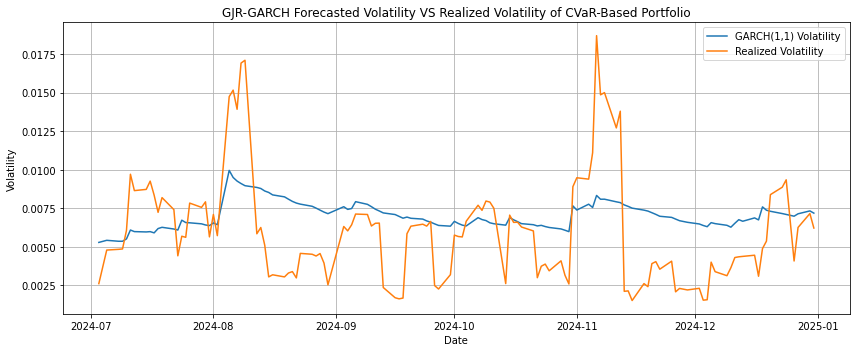

In [72]:
# Forecast VS Realized

plt.figure(figsize=(12, 5))
plt.plot(forecast_gjr_vol, label='GARCH(1,1) Volatility')
plt.plot(real_vol_test, label='Realized Volatility')
plt.title('GJR-GARCH Forecasted Volatility VS Realized Volatility of CVaR-Based Portfolio')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

SVR-GARCH Model

Three kind.
* linear
* Polynomial
* Radial Basis Function

In [43]:
import numpy as np, pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from arch import arch_model

In [44]:
return_CVaR = portfolio_daily_return_CVaR["Portfolio Return"].dropna()


# Generate Features

X_CVaR = pd.concat({
                'r_lag1': return_CVaR.shift(1),
                'r_lag2': return_CVaR.shift(2),
                'r_lag5': return_CVaR.shift(5),
                'r_ma5' : return_CVaR.shift(1).rolling(5).mean(),
                'r_ma10': return_CVaR.shift(1).rolling(10).mean(),
}, axis=1).dropna()

# Target: Portfolio Return
y = return_CVaR.loc[X_CVaR.index]

# Split Data (90:10)
split = int(len(X_CVaR)*0.80)
X_train, X_test = X_CVaR.iloc[:split], X_CVaR.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Estimate Conditional Mean with SVR
svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', 
            SVR(kernel='linear',  # Radial Basis Function
            C=5.0,             # Regularization
            epsilon=0.001,     # Epsilon insentive margin width
            gamma='scale'))
])

svr.fit(X_train, y_train)

# Residuals
yhat_train = pd.Series(svr.predict(X_train), index=X_train.index)
yhat_test = pd.Series(svr.predict(X_test), index=X_test.index)

residual_train = y_train - yhat_train
residual_test = y_test - yhat_test

# Fit GARCH(1,1) on train residual
model_SVR_GARCH = arch_model(residual_test*100,mean='zero',vol='GARCH',p=1,o=1,q=1,dist='t').fit(disp='off')

# Forecast volatility using above fit model
forecast = model_SVR_GARCH.forecast(start=residual_test.index[0])
forecast_vol_SVR = np.sqrt(forecast.variance.iloc[:,0])/100


In [77]:
# Calculate RMSE

real_vol_SVR = return_CVaR.rolling(5).std().loc[forecast_vol_SVR.index]
rmse_svr = RMSE(real_vol_SVR,forecast_vol_SVR)
print(f"The RMSE value of GARCH Model is {rmse_garch:.7f}")
print(f"The RMSE value of GJR-GARCH Model is {rmse_gjr:.7f}")
print(f"The RMSE value of SVR-GARCH Model is {rmse_svr:.7f}")

if rmse_gjr < rmse_svr: 
    print("GJR-GARCH is better.")
elif rmse_gjr == rmse_garch:
    print("Both MSE are the same.")
else: 
    print("SVR-GARCH is better.")


The RMSE value of GARCH Model is 0.0034041
The RMSE value of GJR-GARCH Model is 0.0033963
The RMSE value of SVR-GARCH Model is 0.0027825
SVR-GARCH is better.


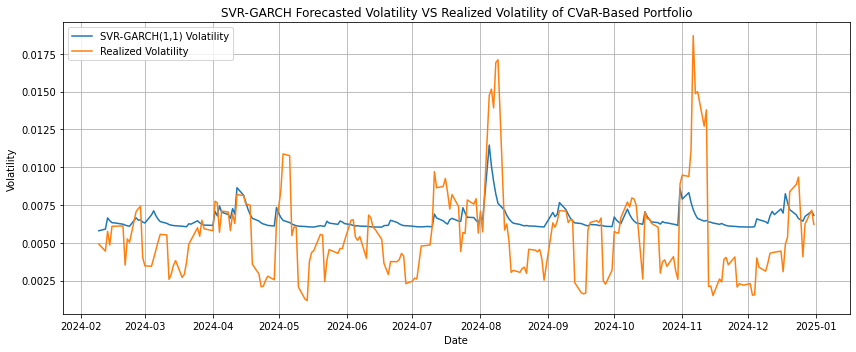

In [78]:
# Forecast VS Realized

plt.figure(figsize=(12, 5))
plt.plot(forecast_vol_SVR, label='SVR-GARCH(1,1) Volatility')
plt.plot(real_vol_SVR, label='Realized Volatility')
plt.title('SVR-GARCH Forecasted Volatility VS Realized Volatility of CVaR-Based Portfolio')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()